# Análisis Exploratorio y Enriquecimiento Semántico de Tweets del Huracán María (`HumAID_maria_tweets.csv`)

Este notebook realiza un análisis exhaustivo del dataset anotado de tweets del huracán María, extraído del repositorio [HumAID Dataset (CrisisNLP, ICWSM 2021)](https://crisisnlp.qcri.org/humaid_dataset). El enfoque es multidimensional, combinando limpieza de texto, ingeniería de características, visualizaciones y análisis de sentimiento para obtener una comprensión profunda del contenido social generado durante el desastre.

---

## Contenido del Análisis:

### 🔹 1. **Carga y limpieza de datos**
- Se renombraron y estructuraron columnas (`tweet_id`, `tweet_text`, `Label`, `Split`) con nombres descriptivos.
- Limpieza textual: eliminación de URLs, menciones, hashtags, espacios extra y conversión a minúsculas.
- Se creó una columna `Clean_Text` como base para análisis posteriores.

---

### 🔹 2. **Ingeniería de características**
- **Longitud de texto:** columnas `Tweet_Length` y `Tweet_Length_Category`.
- **Retweets:** columna `Is_RT` basada en si el tweet inicia con "RT".
- **Énfasis textual:** conteo de signos de exclamación (`exclamation_count`) y uso de palabras en mayúsculas (`caps_count`).
- **Palabras clave:** detección de términos relacionados con ayuda humanitaria (`help`, `food`, `relief`, etc.) por clase.
- **RegEx Features:** detección temática basada en patrones de ayuda, alimento y alertas.

---

### 🔹 3. **Análisis univariado y visualizaciones por variable**
- **Distribuciones:** longitud, palabras, retweets.
- **Gráficos:** histogramas, boxplots, gráficos de barras, pastel, waffle y `FacetGrid`.
- **Etiquetas (`Label`), conjuntos (`Split`) y retweets (`Is_RT`)** son explorados individualmente y en conjunto.
- **Nubes de palabras (`WordCloud`)** para explorar vocabulario por clase.

---

### 🔹 4. **Frecuencia de N-gramas**
- Análisis de 1-gramas y 2-gramas para cada clase usando `CountVectorizer`.
- Visualizaciones guardadas para los n-gramas más frecuentes por categoría (`Label`).

---

### 🔹 5. **Presencia de palabras clave**
- Conteo agregado de keywords por clase.
- Visualización de frecuencia en gráfico de barras.
- Features binarios y numéricos construidos usando expresiones regulares.

---

### 🔹 6. **Representación del vocabulario y métricas léxicas**
- Cálculo del tamaño del vocabulario.
- Proporción de palabras únicas (`hapax legomena`).
- Métricas útiles para comprender la diversidad léxica.

---

### 🔹 7. **TF-IDF + Reducción de Dimensionalidad**
- Extracción de características con **TF-IDF** usando n-gramas de tamaño 1 a 3.
- Visualizaciones con técnicas de reducción de dimensionalidad:
  - **UMAP**
  - **t-SNE**
- Coloreado por clase `Label`.

---

### 🔹 8. **Análisis de sentimiento con VADER**
- Aplicación de VADER (Valence Aware Dictionary and sEntiment Reasoner).
- Cálculo del puntaje `compound` para cada tweet.
- Clasificación de sentimiento (`positive`, `neutral`, `negative`) con umbrales estándar.
- Visualización con boxplot de distribución de sentimiento por categoría `Label`.

---

## 🔍 Objetivo General

Extraer patrones informativos del contenido textual de los tweets relacionados con el desastre natural, evaluar la utilidad de distintas técnicas de NLP y visualizar fenómenos sociolingüísticos en contextos de emergencia.

Este análisis no solo sirve como informe técnico, sino como punto de partida para futuros modelos de clasificación automática o análisis semántico en tareas humanitarias basadas en redes sociales.

## 1. Importar bibliotecas

Las siguientes bibliotecas se utilizarán a lo largo del cuaderno.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pywaffle import Waffle
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re


## 2. Carga de datos

Cargar CSV en un DataFrame de Pandas.

In [2]:
# Cargar CSV con cabecera deducida
df = pd.read_csv('HumAID_maria_tweets.csv')

print("Datos cargados. Número de filas:", df.shape[0])
df.head()

Datos cargados. Número de filas: 7278


tweet_id                                         tweet_text  \
0  914134332226330625  San Juan: Trump lashes out with good reason. #...   
1  910783670134476800  Hurricane Maria Live Updates: Catastrophic Flo...   
2  912134938727780355  Getting food to the island is, obviously, crit...   
3  910669838842056704  My heart breaks for the families in Puerto Ric...   
4  912287091026997248  #B-FAST sending medical, reconstruction &amp; ...   

                              class_label  split  
0              other_relevant_information  train  
1                      caution_and_advice  train  
2  rescue_volunteering_or_donation_effort  train  
3                    sympathy_and_support  train  
4  rescue_volunteering_or_donation_effort  train

## 3. Exploración rápida

Inspeccionemos rápidamente los datos.

In [3]:
# Ver las primeras y últimas filas
print(df.head())
print(df.tail())

# Información resumida
df.info()
print(df.describe(include='all'))

# Comprobar si hay valores nulos
print(df.isnull().sum())

# Tipos de datos
print(df.dtypes)

             tweet_id                                         tweet_text  \
0  914134332226330625  San Juan: Trump lashes out with good reason. #...   
1  910783670134476800  Hurricane Maria Live Updates: Catastrophic Flo...   
2  912134938727780355  Getting food to the island is, obviously, crit...   
3  910669838842056704  My heart breaks for the families in Puerto Ric...   
4  912287091026997248  #B-FAST sending medical, reconstruction &amp; ...   

                              class_label  split  
0              other_relevant_information  train  
1                      caution_and_advice  train  
2  rescue_volunteering_or_donation_effort  train  
3                    sympathy_and_support  train  
4  rescue_volunteering_or_donation_effort  train  
                tweet_id                                         tweet_text  \
7273  914248243885699072  Good lord, its true. Puerto Rico: Teamsters un...   
7274  911834660669444096  #LITechNews: New Yorkers Pitch In To Help With...   


## 4. Limpieza de datos e ingeniería de características

El conjunto de datos `HumAID_maria_tweets.csv` fue preprocesado para estructurarlo de manera útil para análisis exploratorio y posteriores visualizaciones. Los pasos realizados fueron los siguientes:

- Se renombraron las columnas (`tweet_id`, `tweet_text`, `class_label`, `split`) con nombres más descriptivos y consistentes.
- Se añadió una columna `Tweet_Length` para registrar la longitud (en caracteres) de cada tweet.
- Se definieron rangos de longitud para los tweets y se creó una columna categórica `Tweet_Length_Category`, que clasifica los tweets como "Muy Corto", "Corto", "Medio", "Largo" o "Muy Largo".
- Se añadió una columna `Is_RT` que detecta si el tweet es un retweet, basada en si el texto inicia con `"RT"`.
- Se convirtieron las columnas `Label` y `Split` al tipo categórico para optimizar almacenamiento y análisis.

Este proceso resulta en un DataFrame limpio y enriquecido, listo para análisis basados en contenido, longitud y tipo de tweet.


In [4]:
# =============================================
# LIMPIEZA DE DATOS E INGENIERÍA DE CARACTERÍSTICAS
# =============================================

# Paso 0: Cargar CSV
df = pd.read_csv('HumAID_maria_tweets.csv')

# Paso 1: Renombrar columnas para facilitar su uso
df = df.rename(columns={
    "tweet_id": "Tweet_ID",
    "tweet_text": "Tweet_Text",
    "class_label": "Label",
    "split": "Split"
})

# Paso 2: Crear columna con longitud del tweet (útil para análisis)
df["Tweet_Length"] = df["Tweet_Text"].str.len()

# Paso 3: Clasificar longitud del tweet por rangos
length_bins = [0, 80, 120, 140, 240, df["Tweet_Length"].max()]
length_labels = ["Muy Corto", "Corto", "Medio", "Largo", "Muy Largo"]

df["Tweet_Length_Category"] = pd.cut(
    df["Tweet_Length"],
    bins=length_bins,
    labels=length_labels,
    include_lowest=True
)

# Paso 4: Añadir columna para detectar si es un retweet
df["Is_RT"] = df["Tweet_Text"].str.startswith("RT")

# Paso 5: Convertir variables categóricas (opcional pero útil)
df["Label"] = df["Label"].astype("category")
df["Split"] = df["Split"].astype("category")

# Paso 6: Crear DataFrame de trabajo
df_selected = df[[
    "Tweet_ID", "Tweet_Text", "Label", "Split",
    "Tweet_Length", "Tweet_Length_Category", "Is_RT"
]].copy()

# Verificación
print(df_selected.head())


             Tweet_ID                                         Tweet_Text  \
0  914134332226330625  San Juan: Trump lashes out with good reason. #...   
1  910783670134476800  Hurricane Maria Live Updates: Catastrophic Flo...   
2  912134938727780355  Getting food to the island is, obviously, crit...   
3  910669838842056704  My heart breaks for the families in Puerto Ric...   
4  912287091026997248  #B-FAST sending medical, reconstruction &amp; ...   

                                    Label  Split  Tweet_Length  \
0              other_relevant_information  train            92   
1                      caution_and_advice  train            96   
2  rescue_volunteering_or_donation_effort  train            51   
3                    sympathy_and_support  train           139   
4  rescue_volunteering_or_donation_effort  train           126   

  Tweet_Length_Category  Is_RT  
0                 Corto  False  
1                 Corto  False  
2             Muy Corto  False  
3             

## 5. Análisis y exploración de datos

### 🟦 SECCIÓN A: Análisis Univariado — Longitud del Tweet

Esta sección muestra diferentes visualizaciones y estadísticas descriptivas para comprender la distribución y características de la longitud de los tweets. Se incluyen:
- **Histograma y KDE:** Muestran la distribución de la longitud de los tweets, permitiendo identificar patrones y tendencias generales.
- **Boxplot:** Facilita la detección de valores atípicos y la dispersión de la longitud.
- **Gráfico de barras y Waffle Chart:** Agrupan los tweets en categorías (Muy Corto, Corto, Medio, Largo, Muy Largo) para visualizar la cantidad en cada rango.
- **Comparación entre retweets y originales:** Permite observar diferencias en la longitud según si el tweet es retweet o no.
- **Estadísticas descriptivas:** Resumen la información con medidas como la media, mediana y moda.

---

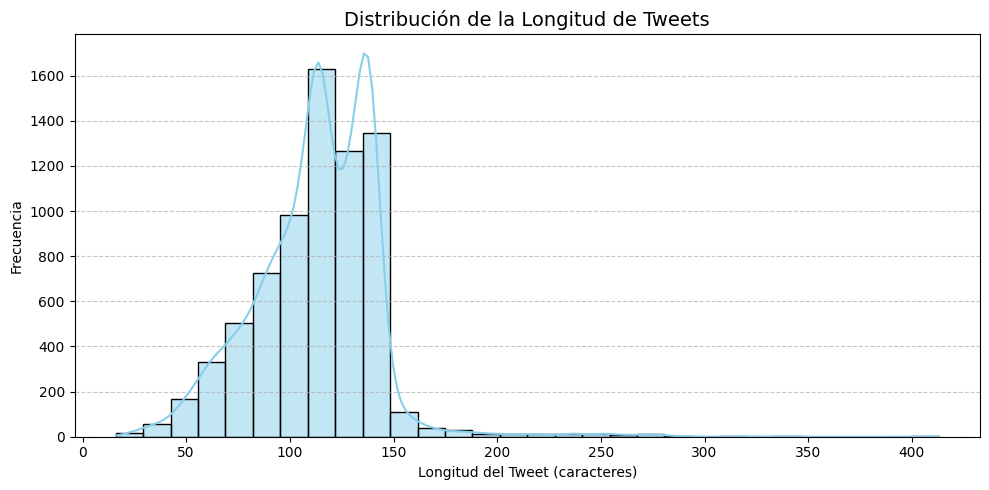

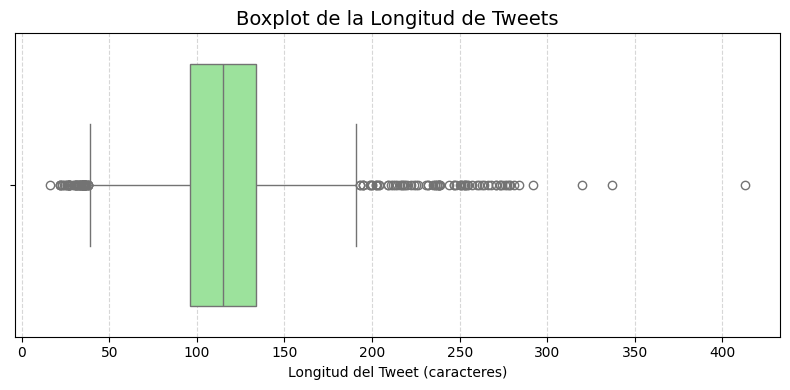

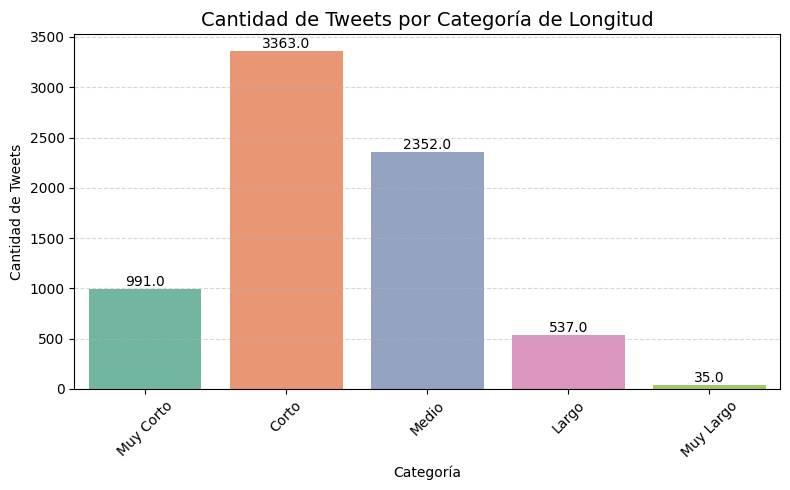

📌 Estadísticas de longitud de tweets:
Promedio: 112.73
Mediana: 115.0
Moda: 139


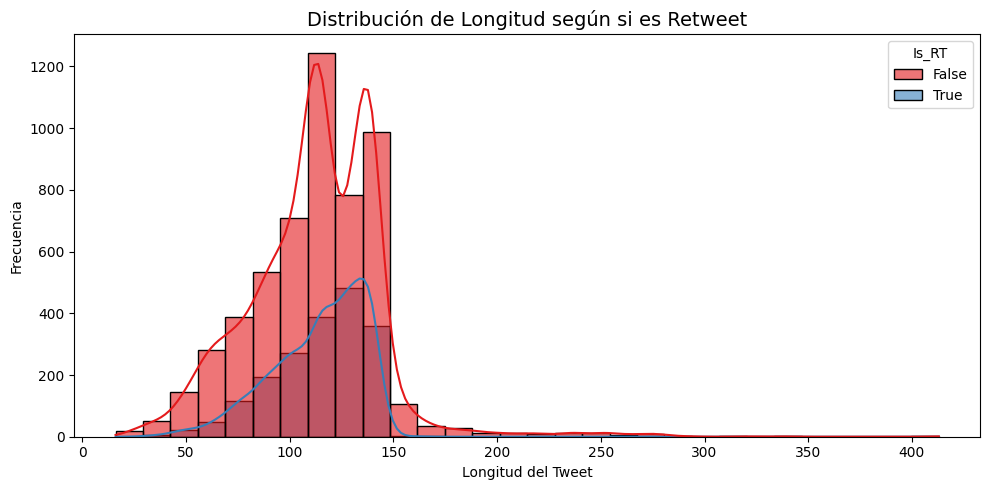

In [5]:
# ======================================================
# SECCIÓN A: ANÁLISIS UNIVARIADO — LONGITUD DEL TWEET
# ======================================================

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(df_selected["Tweet_Length"], bins=30, kde=True, color="skyblue")
plt.title("Distribución de la Longitud de Tweets", fontsize=14)
plt.xlabel("Longitud del Tweet (caracteres)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_selected["Tweet_Length"], color="lightgreen")
plt.title("Boxplot de la Longitud de Tweets", fontsize=14)
plt.xlabel("Longitud del Tweet (caracteres)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Gráfico de barras por categoría de longitud
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="Tweet_Length_Category",
    hue="Tweet_Length_Category",
    data=df_selected,
    order=length_labels,
    palette="Set2",
    legend=False
)

# Añadir etiquetas numéricas
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.title("Cantidad de Tweets por Categoría de Longitud", fontsize=14)
plt.xlabel("Categoría")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("📌 Estadísticas de longitud de tweets:")
print(f"Promedio: {df_selected['Tweet_Length'].mean():.2f}")
print(f"Mediana: {df_selected['Tweet_Length'].median()}")
print(f"Moda: {df_selected['Tweet_Length'].mode()[0]}")

# Distribución por retweets vs no retweets
plt.figure(figsize=(10, 5))
sns.histplot(data=df_selected, x="Tweet_Length", hue="Is_RT", bins=30, kde=True, palette="Set1", alpha=0.6)
plt.title("Distribución de Longitud según si es Retweet", fontsize=14)
plt.xlabel("Longitud del Tweet")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()



### ✅ Análisis

- La distribución de la longitud de los tweets tiene forma casi normal, con una ligera inclinación hacia la derecha. La mayoría de los mensajes se concentran entre **100 y 140 caracteres**, reflejando la antigua limitación de Twitter.
- El **boxplot** muestra que la mayoría de los valores están en el rango de **90 a 140 caracteres**, pero también hay varios **outliers** que superan los 200 e incluso los 400 caracteres.
- En el gráfico de barras por categoría, se observa que los tweets **"Cortos"** (3363) y **"Medios"** (2352) son los más comunes. Muy pocos se clasifican como **"Muy Largos"** (35), lo que confirma la tendencia general hacia mensajes breves.
- La distribución por **retweets (`Is_RT`)** muestra que los **retweets tienden a ser más breves** que los tweets originales, probablemente por estar compuestos de frases concisas o citas.
- Las estadísticas generales de longitud son:
  - **Promedio:** 112.73 caracteres
  - **Mediana:** 115.0 caracteres
  - **Moda:** 139 caracteres

  ---

### 🟦 SECCIÓN B: Análisis Univariado — Variable Label

Esta sección analiza la variable categórica **Label**, que clasifica los tweets en diferentes categorías temáticas. Se utilizan:
- **Barplot:** Para visualizar la frecuencia absoluta de tweets en cada categoría.
- **Gráfico de pastel (Pie Chart):** Para mostrar la proporción relativa de cada categoría, facilitando la identificación de clases predominantes y minoritarias.

---

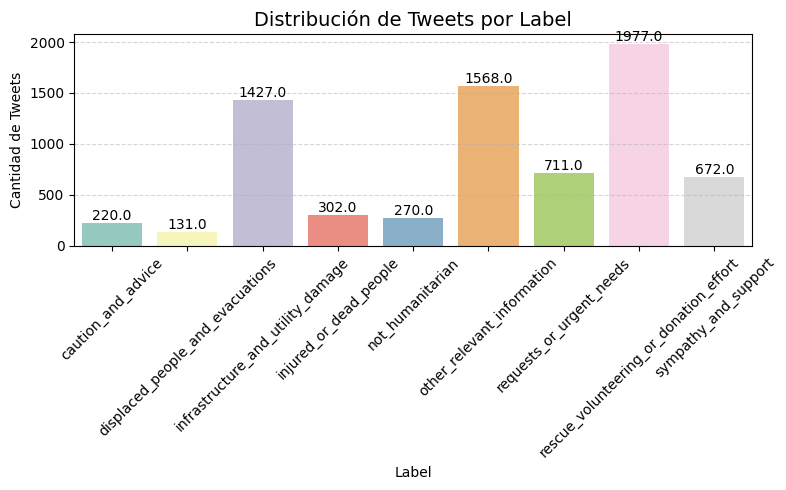

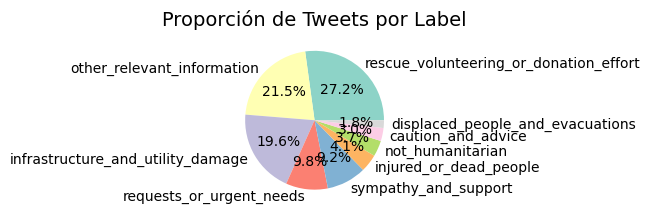

In [6]:
# ======================================================
# SECCIÓN B: ANÁLISIS UNIVARIADO — VARIABLE 'Label'
# ======================================================

# Conteo de tweets por Label con barplot
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="Label",
    hue="Label",
    data=df_selected,
    palette="Set3",
    legend=False
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)
plt.title("Distribución de Tweets por Label", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Pie chart de la distribución de Label
label_counts = df_selected["Label"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set3"))
plt.title("Proporción de Tweets por Label", fontsize=14)
plt.tight_layout()
plt.show()


### ✅ Análisis

- El dataset contiene **9 categorías distintas** de etiquetas (`Label`) que clasifican los tweets según su contenido relacionado con desastres.
- Las categorías más representadas son:
  - **rescue_volunteering_or_donation_effort** (1977 tweets, 27.2%)
  - **other_relevant_information** (1568 tweets, 21.5%)
  - **infrastructure_and_utility_damage** (1427 tweets, 19.6%)
- Las clases menos representadas incluyen:
  - **displaced_people_and_evacuations** (131 tweets)
  - **caution_and_advice** (220 tweets)
  - **not_humanitarian** (270 tweets)

- El gráfico de barras muestra el **desequilibrio** entre clases, donde algunas etiquetas tienen una cantidad de ejemplos significativamente mayor que otras.
- El gráfico circular permite observar la **proporción relativa**, destacando que solo **3 clases concentran más del 68% del total de los tweets**, lo que podría influir en los modelos de clasificación si no se trata con técnicas de balanceo o ponderación.

📌 Este desbalance es importante tenerlo en cuenta antes del entrenamiento de modelos, ya que puede afectar la precisión y el recall en las clases minoritarias.

  ---

### 🟦 SECCIÓN C: Análisis Univariado — Variable Split

Aquí se explora la distribución del conjunto de datos en términos de la variable **Split**, que indica la división de datos en subconjuntos (por ejemplo, train y test). Se utiliza:
- **Gráfico de barras:** Para identificar rápidamente el balance entre los diferentes conjuntos y detectar posibles desbalances en los datos.

---

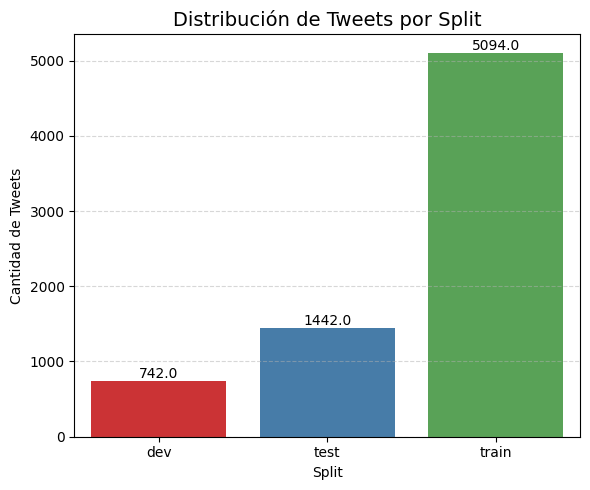

In [7]:
# ======================================================
# SECCIÓN C: ANÁLISIS UNIVARIADO — VARIABLE 'Split'
# ======================================================

plt.figure(figsize=(6, 5))
ax = sns.countplot(
    x="Split",
    hue="Split",
    data=df_selected,
    palette="Set1",
    legend=False
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)
plt.title("Distribución de Tweets por Split", fontsize=14)
plt.xlabel("Split")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### ✅ Análisis

- El conjunto de datos está dividido en tres particiones:
  - **train**: 5094 tweets (≈ 70%)
  - **test**: 1442 tweets (≈ 20%)
  - **dev**: 742 tweets (≈ 10%)

- Esta división es **adecuada para entrenamiento supervisado**, siguiendo una proporción estándar para tareas de clasificación (train/test/dev).

- El gráfico de barras muestra claramente que la mayoría de los ejemplos se encuentran en el conjunto de **entrenamiento**, lo cual es beneficioso para el entrenamiento del modelo.

📌 Es importante asegurarse de que la **distribución de etiquetas (`Label`) esté equilibrada dentro de cada partición** para evitar sesgos durante el entrenamiento o evaluación.

  ---

### 🟦 SECCIÓN D: Análisis Univariado — Texto de los Tweets

En esta sección se profundiza en el contenido textual de los tweets mediante:
- **Conteo de palabras:** Se calcula la cantidad de palabras por tweet, ofreciendo una métrica adicional de longitud.
- **Histograma del número de palabras:** Visualiza la distribución del número de palabras por tweet.
- **WordCloud:** Genera una nube de palabras para identificar visualmente las palabras más frecuentes y relevantes en el conjunto de datos.
- **Ejemplos de tweets:** Muestra ejemplos aleatorios para dar una idea representativa del contenido y estilo de los mensajes.

---

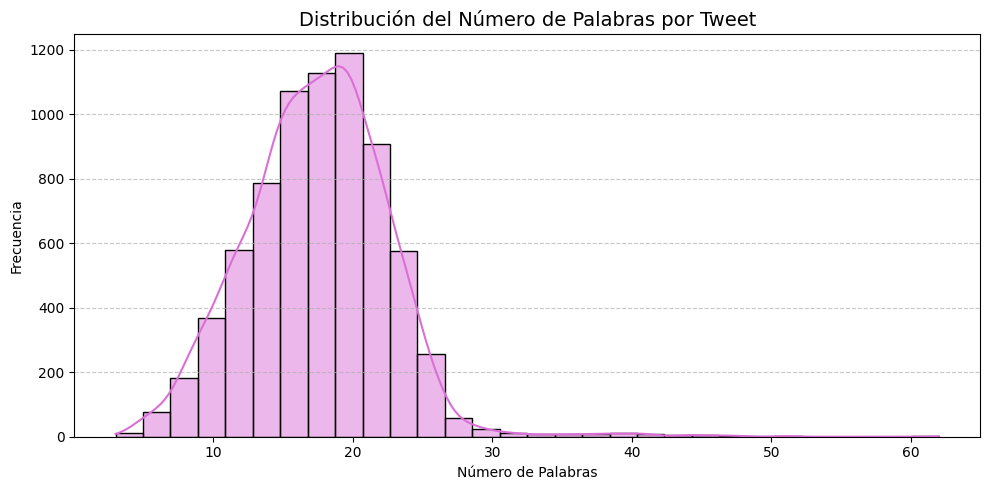

Ejemplos de tweets:
6060    RT @GlindaLoveShoes: Start your week off by do...
6626    #PuertoRico has been US territory since 1898 (...
6750    Abt time! Trump authorized the Jones Act to be...
3689    RT @endgray: this is sad, my best friend lost ...
4516    Urgent Information required from vessels trave...
Name: Tweet_Text, dtype: object


In [8]:
# ======================================================
# SECCIÓN D: ANÁLISIS UNIVARIADO — TWEET_TEXT
# ======================================================

# Crear columna con el conteo de palabras en cada tweet
df_selected["Word_Count"] = df_selected["Tweet_Text"].apply(lambda x: len(x.split()))

# Histograma del número de palabras por tweet
plt.figure(figsize=(10, 5))
sns.histplot(df_selected["Word_Count"], bins=30, kde=True, color="orchid")
plt.title("Distribución del Número de Palabras por Tweet", fontsize=14)
plt.xlabel("Número de Palabras")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar algunos ejemplos de tweets
print("Ejemplos de tweets:")
print(df_selected["Tweet_Text"].sample(5, random_state=42))

### ✅ Análisis

- La distribución del número de palabras por tweet muestra una forma similar a una campana (distribución normal), con un pico alrededor de **18 a 20 palabras por tweet**.
- La mayoría de los tweets contienen entre **10 y 30 palabras**, lo cual es consistente con la limitación de caracteres en la plataforma y la naturaleza breve de los mensajes.
- Aunque algunos tweets llegan a superar las **50 palabras**, son casos muy poco frecuentes.

- Los ejemplos de tweets muestran una variedad de estructuras, desde retweets con comentarios hasta frases informativas, demostrando la diversidad del contenido textual.

📌 Este análisis sugiere que los tweets contienen suficiente información textual para aplicar técnicas de procesamiento de lenguaje natural (NLP) como extracción de palabras clave, análisis de sentimiento, o clasificación por contenido.

  ---

### 🟦 SECCIÓN E: Análisis Univariado — Variable Is_RT

Esta sección se centra en la variable booleana **Is_RT**, que indica si un tweet es retweet. Se incluyen:
- **Gráfico de barras:** Muestra la frecuencia de retweets versus tweets originales, lo cual ayuda a comprender la dinámica de difusión y el comportamiento del contenido en redes sociales.
---

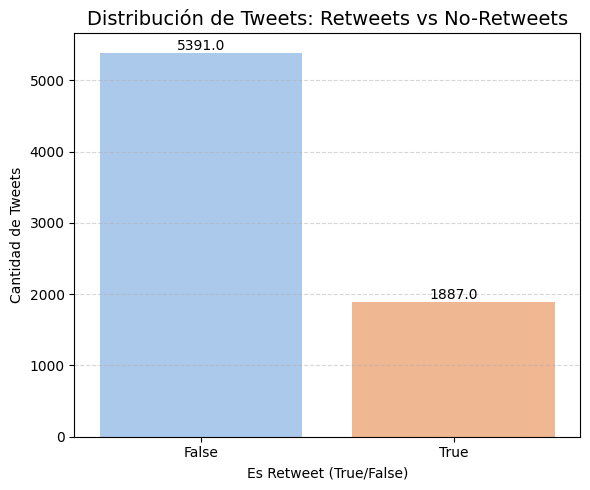

In [9]:
# ======================================================
# SECCIÓN E: ANÁLISIS UNIVARIADO — VARIABLE BOOLEANA 'Is_RT'
# ======================================================

plt.figure(figsize=(6, 5))
ax = sns.countplot(
    x="Is_RT",
    hue="Is_RT",
    data=df_selected,
    palette="pastel",
    legend=False
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)
plt.title("Distribución de Tweets: Retweets vs No-Retweets", fontsize=14)
plt.xlabel("Es Retweet (True/False)")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### ✅ Análisis

- En el conjunto de datos, la mayoría de los tweets **no son retweets**:
  - **No-Retweets (`False`)**: 5391 tweets
  - **Retweets (`True`)**: 1887 tweets

- Esto significa que aproximadamente el **74%** del dataset está compuesto por contenido original, mientras que el **26%** corresponde a retweets.

- Esta diferencia puede ser importante para el análisis de contenido, ya que:
  - Los **retweets** tienden a ser más breves y repetitivos.
  - Los **tweets originales** suelen contener información más rica y diversa.

📌 Considerar esta variable puede ser útil para filtrar duplicados o enriquecer el análisis semántico, especialmente si se busca contenido único o de primera fuente.

  ---

### 🟦 SECCIÓN F: Label vs Longitud del Tweet

**Objetivo:**  
Investigar cómo varía la longitud de los tweets según la categoría asignada en `Label`.

**Visualizaciones:**  
- **Boxplot:** Permite comparar la distribución de la longitud de los tweets entre las distintas etiquetas.
- **Gráfico de barras:** Muestra la media de la longitud de tweets por cada `Label`.

**Análisis esperado:**  
Se podrán identificar diferencias en la extensión de los mensajes según su contenido, lo que puede sugerir que algunas categorías requieren mayor detalle.

---

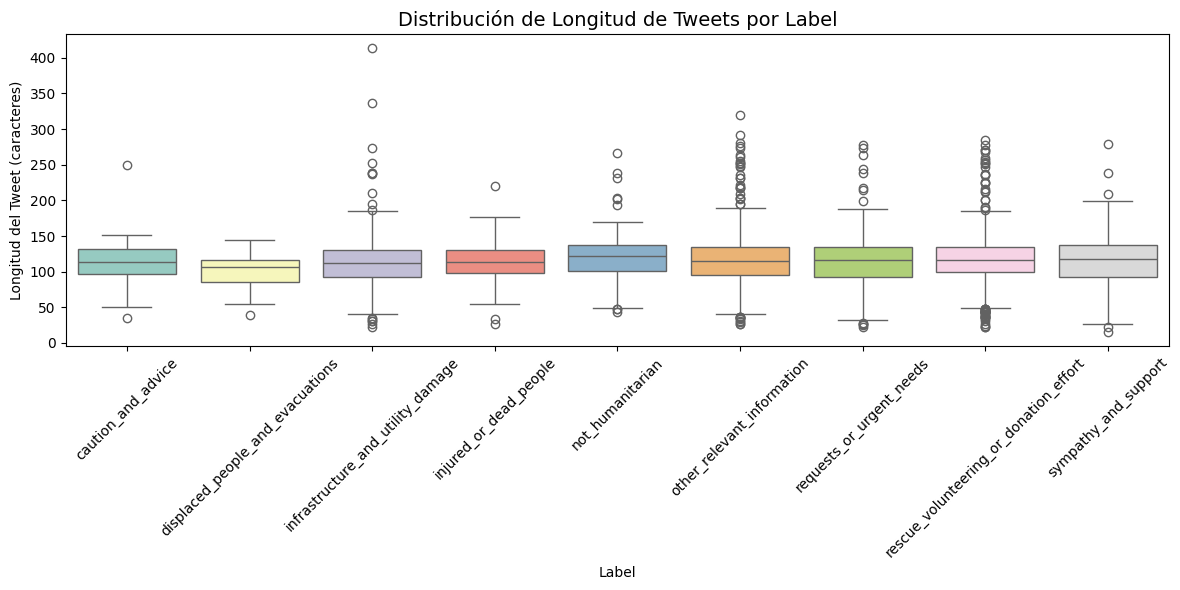

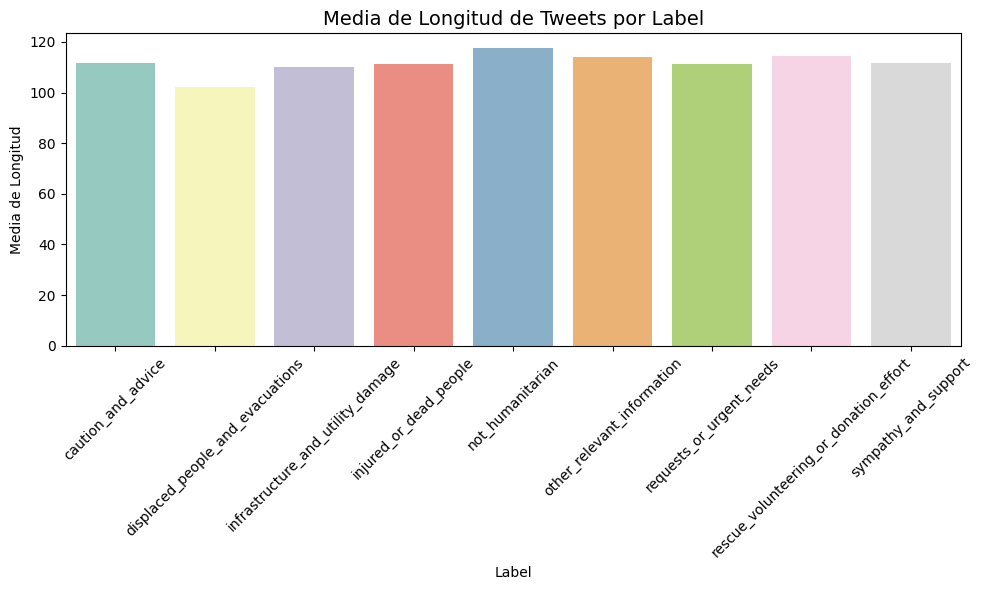

In [10]:
# ======================================================
# SECCIÓN F: Label vs Longitud del Tweet
# ======================================================

# Boxplot por Label
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="Label",
    y="Tweet_Length",
    data=df_selected,
    hue="Label",
    palette="Set3",
    legend=False
)
plt.title("Distribución de Longitud de Tweets por Label", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Longitud del Tweet (caracteres)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de barras: Media de Tweet_Length por Label
mean_length = df_selected.groupby("Label", observed=True)["Tweet_Length"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Label",
    y="Tweet_Length",
    data=mean_length,
    hue="Label",
    palette="Set3",
    legend=False
)
plt.title("Media de Longitud de Tweets por Label", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Media de Longitud")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### ✅ Análisis

- El **boxplot** muestra que la distribución de longitud de los tweets varía ligeramente entre clases. Aunque los rangos son similares, algunas categorías presentan más variabilidad y outliers.
- Las clases como **`infrastructure_and_utility_damage`**, **`not_humanitarian`**, y **`rescue_volunteering_or_donation_effort`** tienen una mayor dispersión, indicando que contienen tanto mensajes cortos como largos.
- Por otro lado, categorías como **`displaced_people_and_evacuations`** y **`caution_and_advice`** muestran menor dispersión y una longitud más consistente.

- En el gráfico de **media de longitud por Label**, se observa que:
  - La longitud promedio de los tweets en todas las clases está en torno a los **110–118 caracteres**.
  - La clase con menor media es **`displaced_people_and_evacuations`**, con cerca de 102 caracteres.
  - Las clases **`not_humanitarian`** y **`rescue_volunteering_or_donation_effort`** lideran con promedios cercanos a 117–118 caracteres.

📌 En general, **las diferencias entre clases no son extremas**, pero sí lo suficientemente notorias como para considerar la longitud del tweet como una **característica auxiliar útil** en tareas de clasificación.

---

### 🟨 SECCIÓN G: Is_RT vs Longitud del Tweet

**Objetivo:**  
Determinar si los retweets (`Is_RT=True`) presentan una longitud distinta en comparación con los tweets originales (`Is_RT=False`).

**Visualizaciones:**  
- **Boxplot:** Comparación directa de la distribución de `Tweet_Length` para retweets y no-retweets.
- **Histograma con KDE:** Visualiza la distribución de la longitud en ambos grupos.

**Análisis esperado:**  
Se espera que los retweets sean, en promedio, más cortos debido a que suelen contener solo citas o fragmentos del contenido original.

---

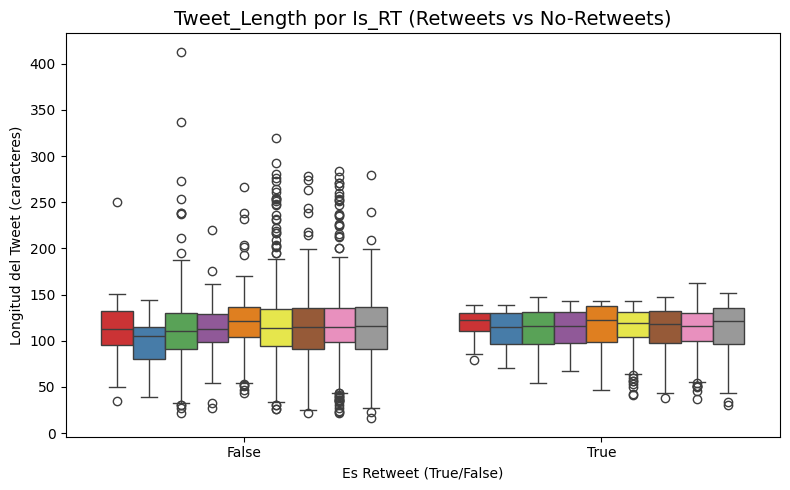

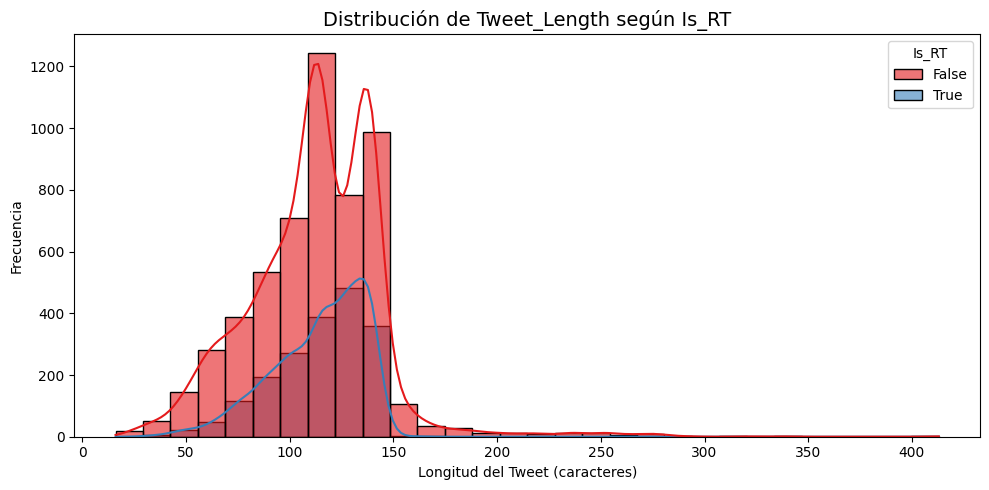

In [11]:
# ======================================================
# SECCIÓN G: Is_RT vs Longitud del Tweet
# ======================================================
plt.figure(figsize=(8, 5))
sns.boxplot(x="Is_RT", y="Tweet_Length", data=df_selected, hue="Label", palette="Set1", legend=False)
plt.title("Tweet_Length por Is_RT (Retweets vs No-Retweets)", fontsize=14)
plt.xlabel("Es Retweet (True/False)")
plt.ylabel("Longitud del Tweet (caracteres)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=df_selected, x="Tweet_Length", hue="Is_RT", bins=30, kde=True, palette="Set1", alpha=0.6)
plt.title("Distribución de Tweet_Length según Is_RT", fontsize=14)
plt.xlabel("Longitud del Tweet (caracteres)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### ✅ Análisis

- El **boxplot** permite observar que los tweets **no retuiteados (`False`)** presentan una mayor variabilidad en su longitud. Hay una amplia gama de valores, con muchos tweets superando los 200 caracteres e incluso casos extremos de más de 400.
- En cambio, los **retweets (`True`)** tienden a estar mucho más concentrados en torno a los **120–140 caracteres**, con muy pocos outliers.

- El **histograma con KDE** refuerza esta observación:  
  - La curva de los **tweets originales (False)** tiene una forma más ancha y diversa, con múltiples picos.
  - La curva de los **retweets (True)** es más angosta y simétrica, con un pico claro entre **110 y 130 caracteres**.

📌 Estos resultados confirman que los **retweets son más breves y estructuralmente consistentes**, mientras que los tweets originales pueden ser considerablemente más extensos o variables. Esta diferencia puede ser aprovechada para:
- Filtrar contenido duplicado.
- Usar `Is_RT` y `Tweet_Length` como **features complementarias** en modelos de clasificación de contenido.

---

### 🟧 SECCIÓN H: WordCloud y Frecuencia por Label

**Objetivo:**  
Analizar las palabras más frecuentes en los tweets para cada categoría (`Label`), lo que puede revelar términos característicos o patrones temáticos.

**Visualizaciones:**  
- **WordClouds:** Una para cada `Label`, que visualiza la prominencia de términos.
- **Conteo de palabras:** Posiblemente con gráficos de barras para las palabras más comunes por categoría.

**Análisis esperado:**  
Cada etiqueta debería mostrar un conjunto de palabras clave que refuercen la naturaleza del contenido de esa categoría (por ejemplo, términos relacionados con ayuda, desastres o información relevante).

---

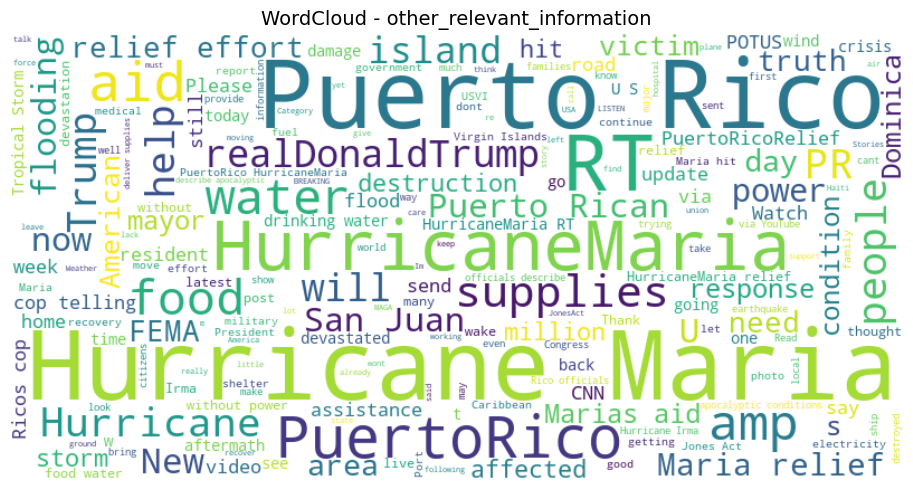

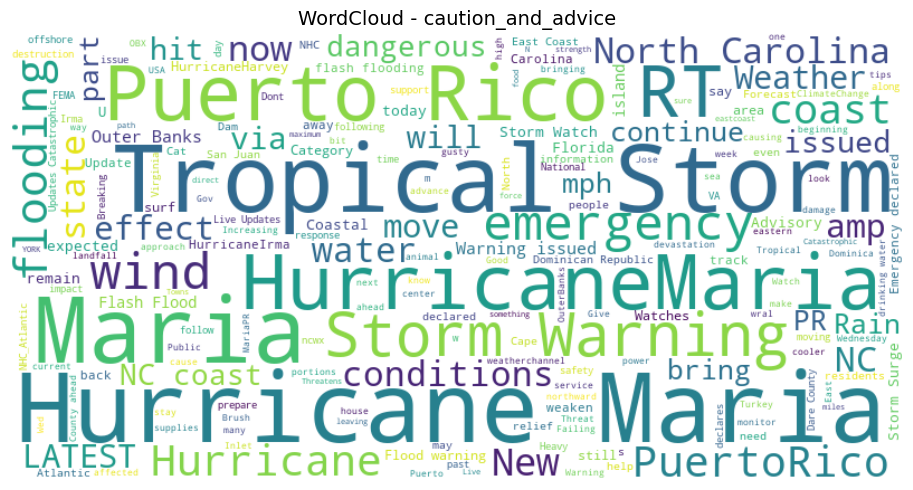

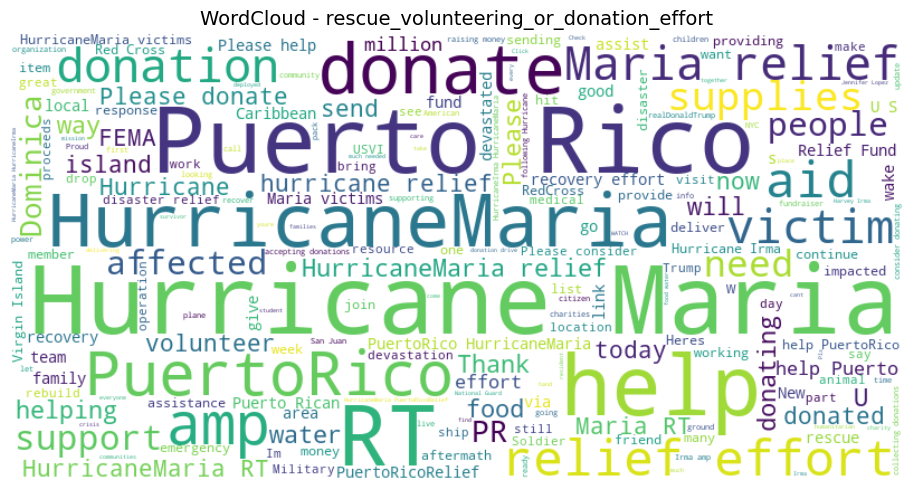

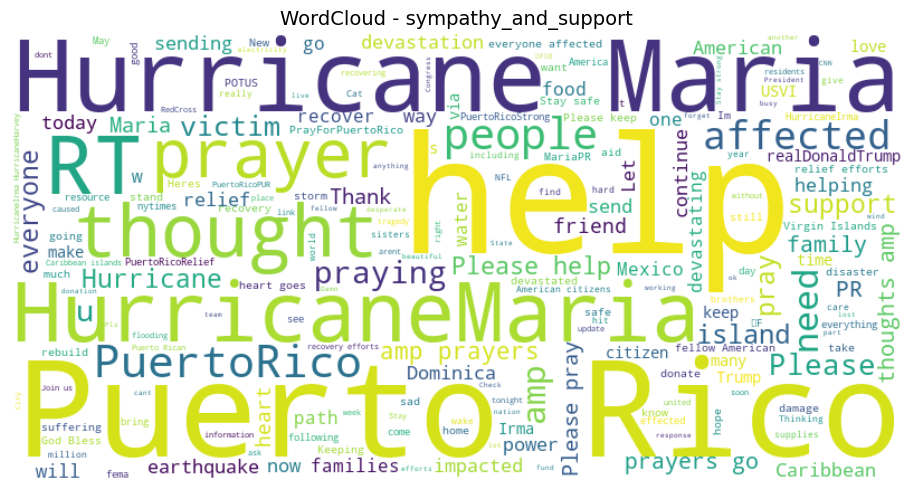

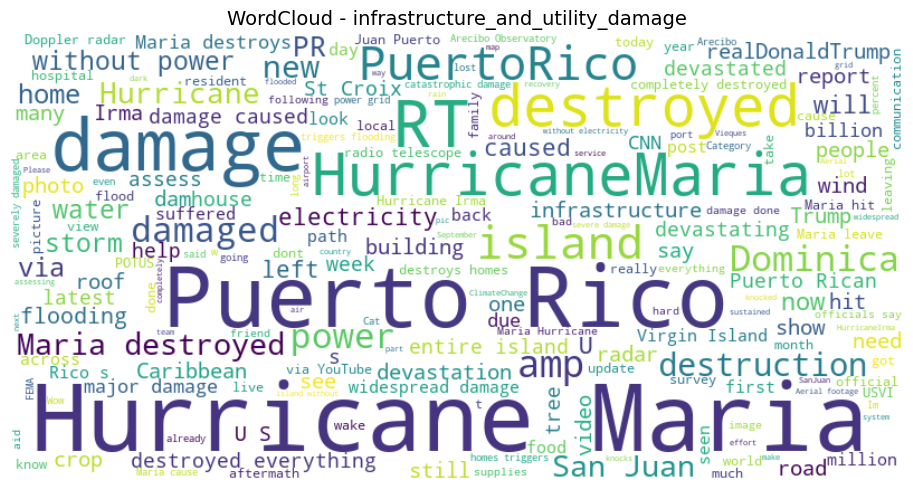

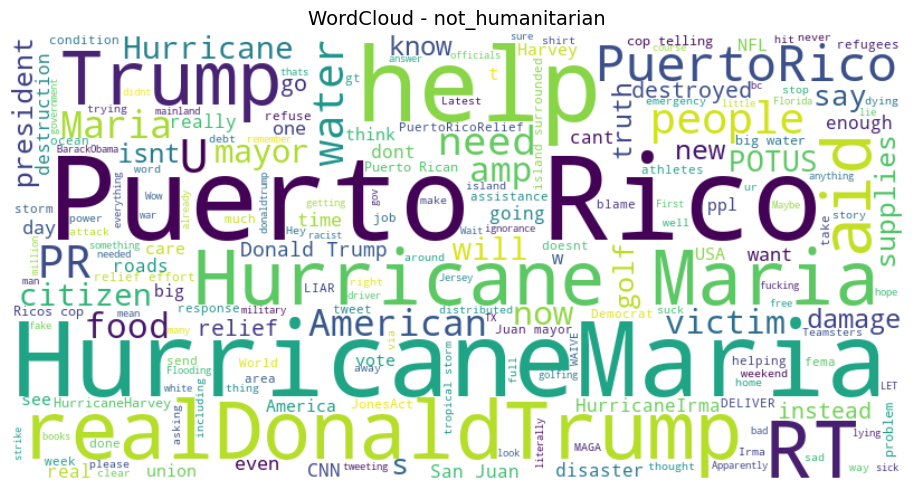

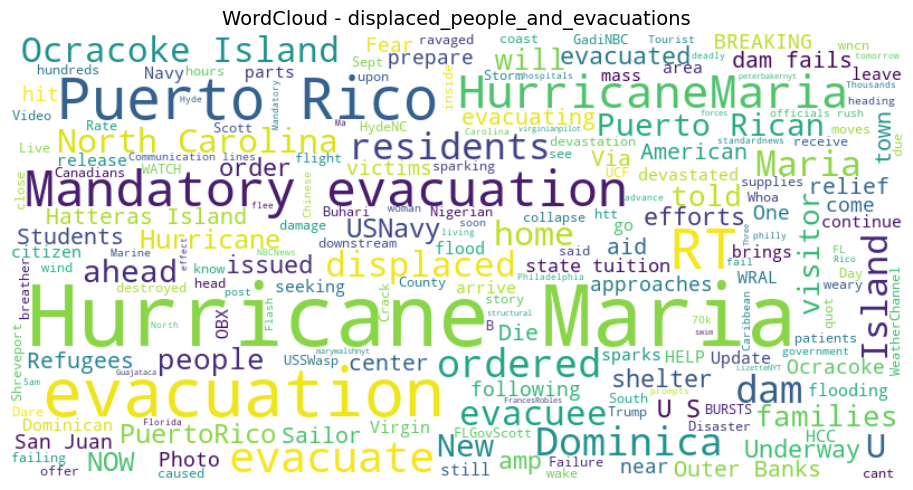

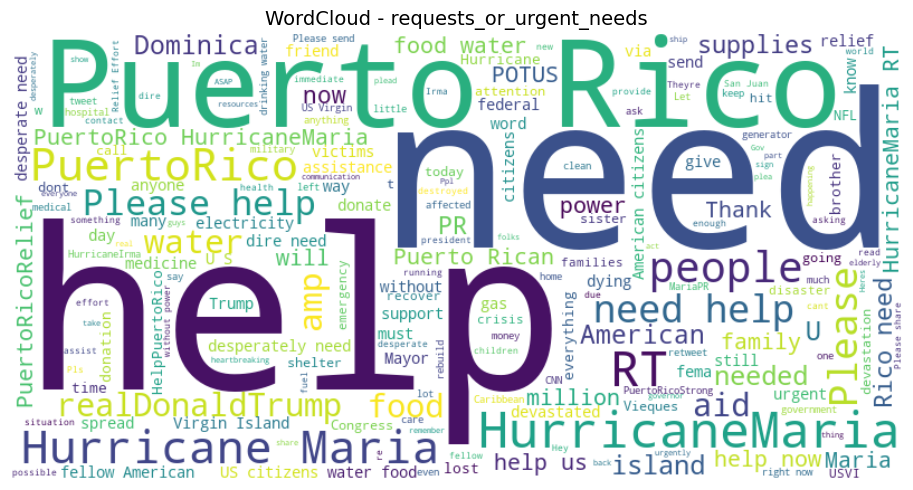

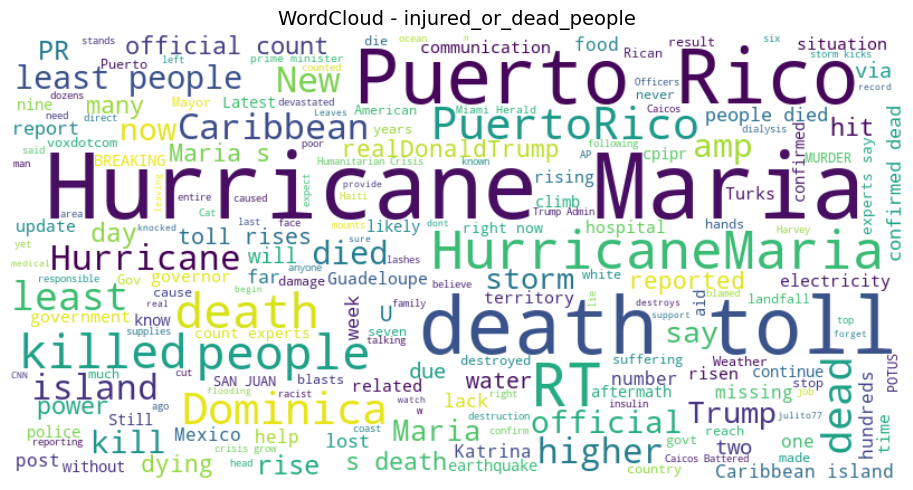

In [12]:
# ======================================================
# SECCIÓN H: WordCloud y Frecuencia por Label
# ======================================================
from wordcloud import WordCloud

labels = df_selected["Label"].unique()
for label in labels:
    text = " ".join(df_selected[df_selected["Label"] == label]["Tweet_Text"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

### ✅ Análisis

- Las nubes de palabras generadas para cada etiqueta (`Label`) permiten identificar los términos más representativos del contenido en cada clase, lo que aporta una comprensión semántica muy valiosa.

#### 📌 Observaciones por clase:

- **`other_relevant_information`**:  
  Términos como *“Puerto Rico”*, *“Hurricane Maria”*, *“water”*, *“food”*, *“aid”* y *“supplies”* son predominantes, indicando información general y logística sobre el desastre.

- **`caution_and_advice`**:  
  Se destacan palabras como *“Tropical Storm”*, *“warning”*, *“emergency”*, *“coast”* y *“flooding”*, lo cual confirma que esta clase agrupa alertas meteorológicas y mensajes preventivos.

- **`rescue_volunteering_or_donation_effort`**:  
  Dominan términos como *“help”*, *“donate”*, *“relief”*, *“support”*, *“volunteer”* y *“aid”*, todos relacionados con la acción social y humanitaria.

- **`sympathy_and_support`**:  
  Palabras emocionales como *“pray”*, *“thoughts”*, *“help”*, *“support”*, *“affected”* y *“family”* son frecuentes, evidenciando una carga de solidaridad y empatía.

- **`infrastructure_and_utility_damage`**:  
  Aparecen términos como *“destroyed”*, *“electricity”*, *“power”*, *“damage”* y *“infrastructure”*, reflejando el impacto físico sobre estructuras y servicios.

- **`not_humanitarian`**:  
  Contiene palabras como *“Trump”*, *“realDonaldTrump”*, *“politics”*, *“president”*, con una mezcla de opiniones, críticas y contenido político.

- **`displaced_people_and_evacuations`**:  
  Términos clave como *“evacuate”*, *“evacuation”*, *“ordered”*, *“residents”* y *“shelter”* indican movimientos forzados de población.

- **`injured_or_dead_people`**:  
  Palabras como *“death toll”*, *“killed”*, *“dead”*, *“confirmed”*, *“official”* y *“hospital”* evidencian el enfoque en víctimas fatales o heridas.

📌 En resumen:
- Las WordClouds reflejan que **cada clase posee un vocabulario dominante y temáticamente coherente**, lo cual es útil para:
  - Ingeniería de características basada en palabras clave.
  - Entrenamiento de modelos NLP orientados a clasificación temática.
  - Generación de reglas heurísticas para etiquetado preliminar.

Estas representaciones son una herramienta exploratoria poderosa para comprender el contenido textual y validar la coherencia de las etiquetas en el dataset.

---

### 🟥 SECCIÓN I: Split vs Distribución de Clases (Label)

**Objetivo:**  
Evaluar la consistencia en la distribución de etiquetas (`Label`) a través de los subconjuntos de datos (`Split`: train, test, dev).

**Visualizaciones:**  
- **Heatmap:** Muestra los porcentajes de cada `Label` en cada `Split`.
- **Gráfico de barras apiladas:** Permite comparar la cantidad de tweets por clase en cada partición.

**Análisis esperado:**  
Se busca detectar si existe un desbalance entre los conjuntos, lo cual podría afectar la generalización y la evaluación del modelo.

---

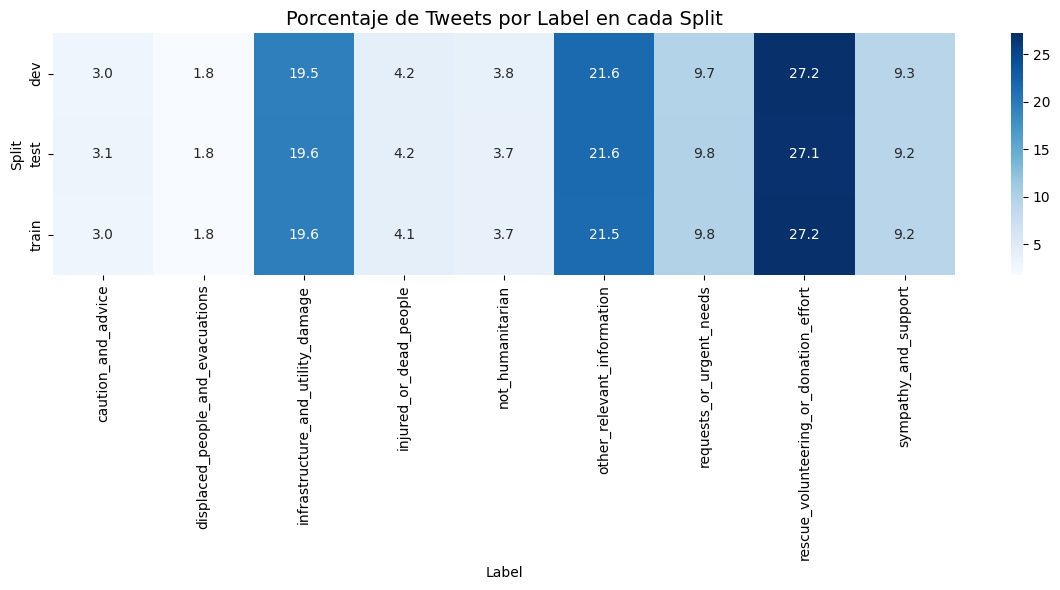

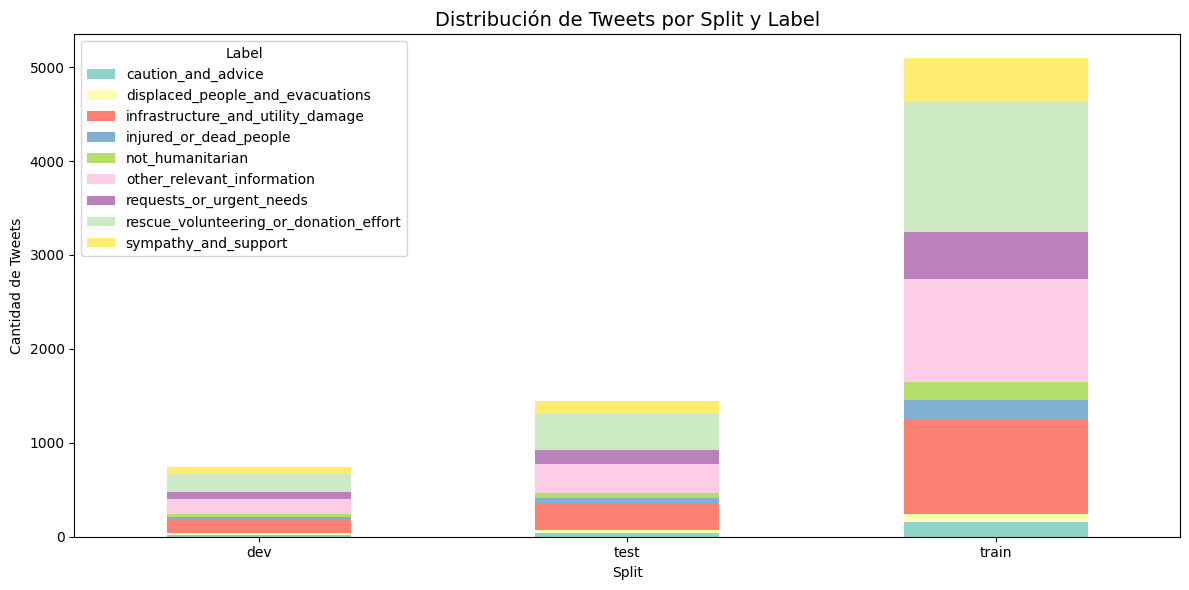

In [13]:
# ======================================================
# SECCIÓN I: Split vs Distribución de Clases (Label)
# ======================================================
# Tabla cruzada de porcentajes
ct = pd.crosstab(df_selected["Split"], df_selected["Label"], normalize='index') * 100
plt.figure(figsize=(12, 6))
sns.heatmap(ct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Porcentaje de Tweets por Label en cada Split", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Split")
plt.tight_layout()
plt.show()

# Gráfico de barras apiladas
ct_counts = pd.crosstab(df_selected["Split"], df_selected["Label"])
ct_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="Set3")
plt.title("Distribución de Tweets por Split y Label", fontsize=14)
plt.xlabel("Split")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### ✅ Análisis

- El **heatmap** muestra el porcentaje de cada clase (`Label`) dentro de cada partición del dataset (`Split`: train, test, dev).
- Los valores son notablemente estables entre splits, lo que indica que la distribución de clases se mantuvo prácticamente constante al dividir los datos.

#### 📌 Ejemplos consistentes:
- `rescue_volunteering_or_donation_effort`: ~27.2% en todos los conjuntos.
- `other_relevant_information`: ~21.5–21.6%.
- `infrastructure_and_utility_damage`: ~19.5–19.6%.

- El **gráfico de barras apiladas** complementa esta información al mostrar la **cantidad total de tweets** por clase en cada `Split`, reflejando que:
  - El conjunto **train** contiene más datos (como es esperado).
  - Las proporciones de clases visualmente coinciden con las del heatmap.

📌 Conclusión:
- La distribución balanceada entre los conjuntos garantiza que los modelos entrenados no estarán sesgados hacia ciertas clases solo por cómo fueron distribuidos los datos.
- **No se evidencia data leakage ni desbalance entre splits**, lo que valida la calidad del preprocesamiento y división original del dataset.

---

### 🟫 SECCIÓN J: Label vs Is_RT

**Objetivo:**  
Analizar la relación entre la categoría (`Label`) y la frecuencia de retweets (`Is_RT`).

**Visualizaciones:**  
- **Gráfico de barras:** Cuenta de tweets por `Label` desglosado por retweets y no-retweets.

**Análisis esperado:**  
Se podrán identificar cuáles categorías tienden a ser más compartidas (mayor proporción de retweets), lo que podría indicar la viralidad o el impacto del mensaje.

---

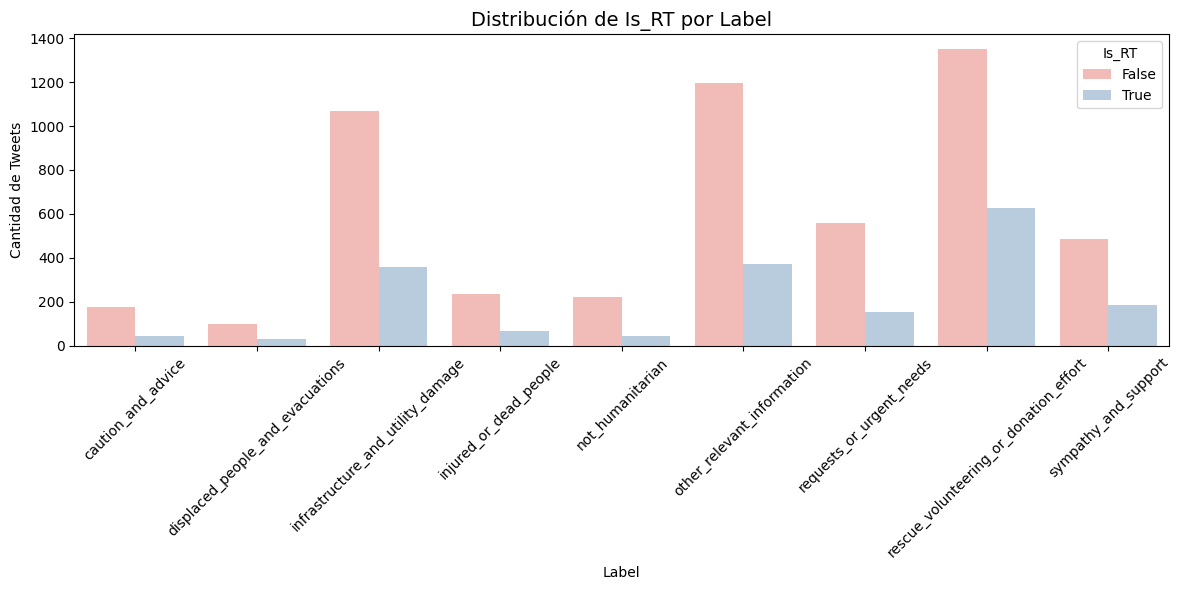

In [14]:
# ======================================================
# SECCIÓN J: Label vs Is_RT
# ======================================================
plt.figure(figsize=(12, 6))
sns.countplot(x="Label", hue="Is_RT", data=df_selected, palette="Pastel1")
plt.title("Distribución de Is_RT por Label", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Cantidad de Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ✅ Análisis

- El gráfico muestra cómo se distribuyen los **retweets (`Is_RT=True`)** y los **tweets originales (`Is_RT=False`)** en cada clase (`Label`).
- En todas las categorías, la cantidad de **tweets originales supera ampliamente a los retweets**, pero algunas clases tienen una proporción notablemente mayor de retweets que otras.

#### 📌 Observaciones destacadas:

- **`rescue_volunteering_or_donation_effort`** y **`other_relevant_information`** son las clases con mayor cantidad absoluta de retweets, con más de **600** y **370** respectivamente.
- Estas clases probablemente contienen contenido **más compartido o viral**, como llamados a la acción, actualizaciones oficiales o enlaces útiles.
- Las clases con menor número de retweets son:
  - **`displaced_people_and_evacuations`**
  - **`not_humanitarian`**
  - **`caution_and_advice`**

📌 Conclusión:
- Este análisis sugiere que algunas clases son **más propensas a ser retuiteadas** que otras, lo que podría reflejar la **relevancia social** o **nivel de difusión** de cierto tipo de mensajes.
- La variable `Is_RT` podría ser útil como **característica auxiliar** en modelos de clasificación o como filtro previo para estudiar solo contenido original.

---

### 🟩 SECCIÓN K: Exploración Multivariable

**Objetivo:**  
Combinar múltiples variables para observar patrones complejos en los datos.

**Visualizaciones:**  
- **FacetGrid:** Permite explorar la distribución de `Tweet_Length` a través de las combinaciones de `Label` y `Split`.

**Análisis esperado:**  
Esta visualización ayudará a identificar interacciones entre las variables, como diferencias en la longitud de los tweets según la categoría y su partición en el conjunto de datos.

---

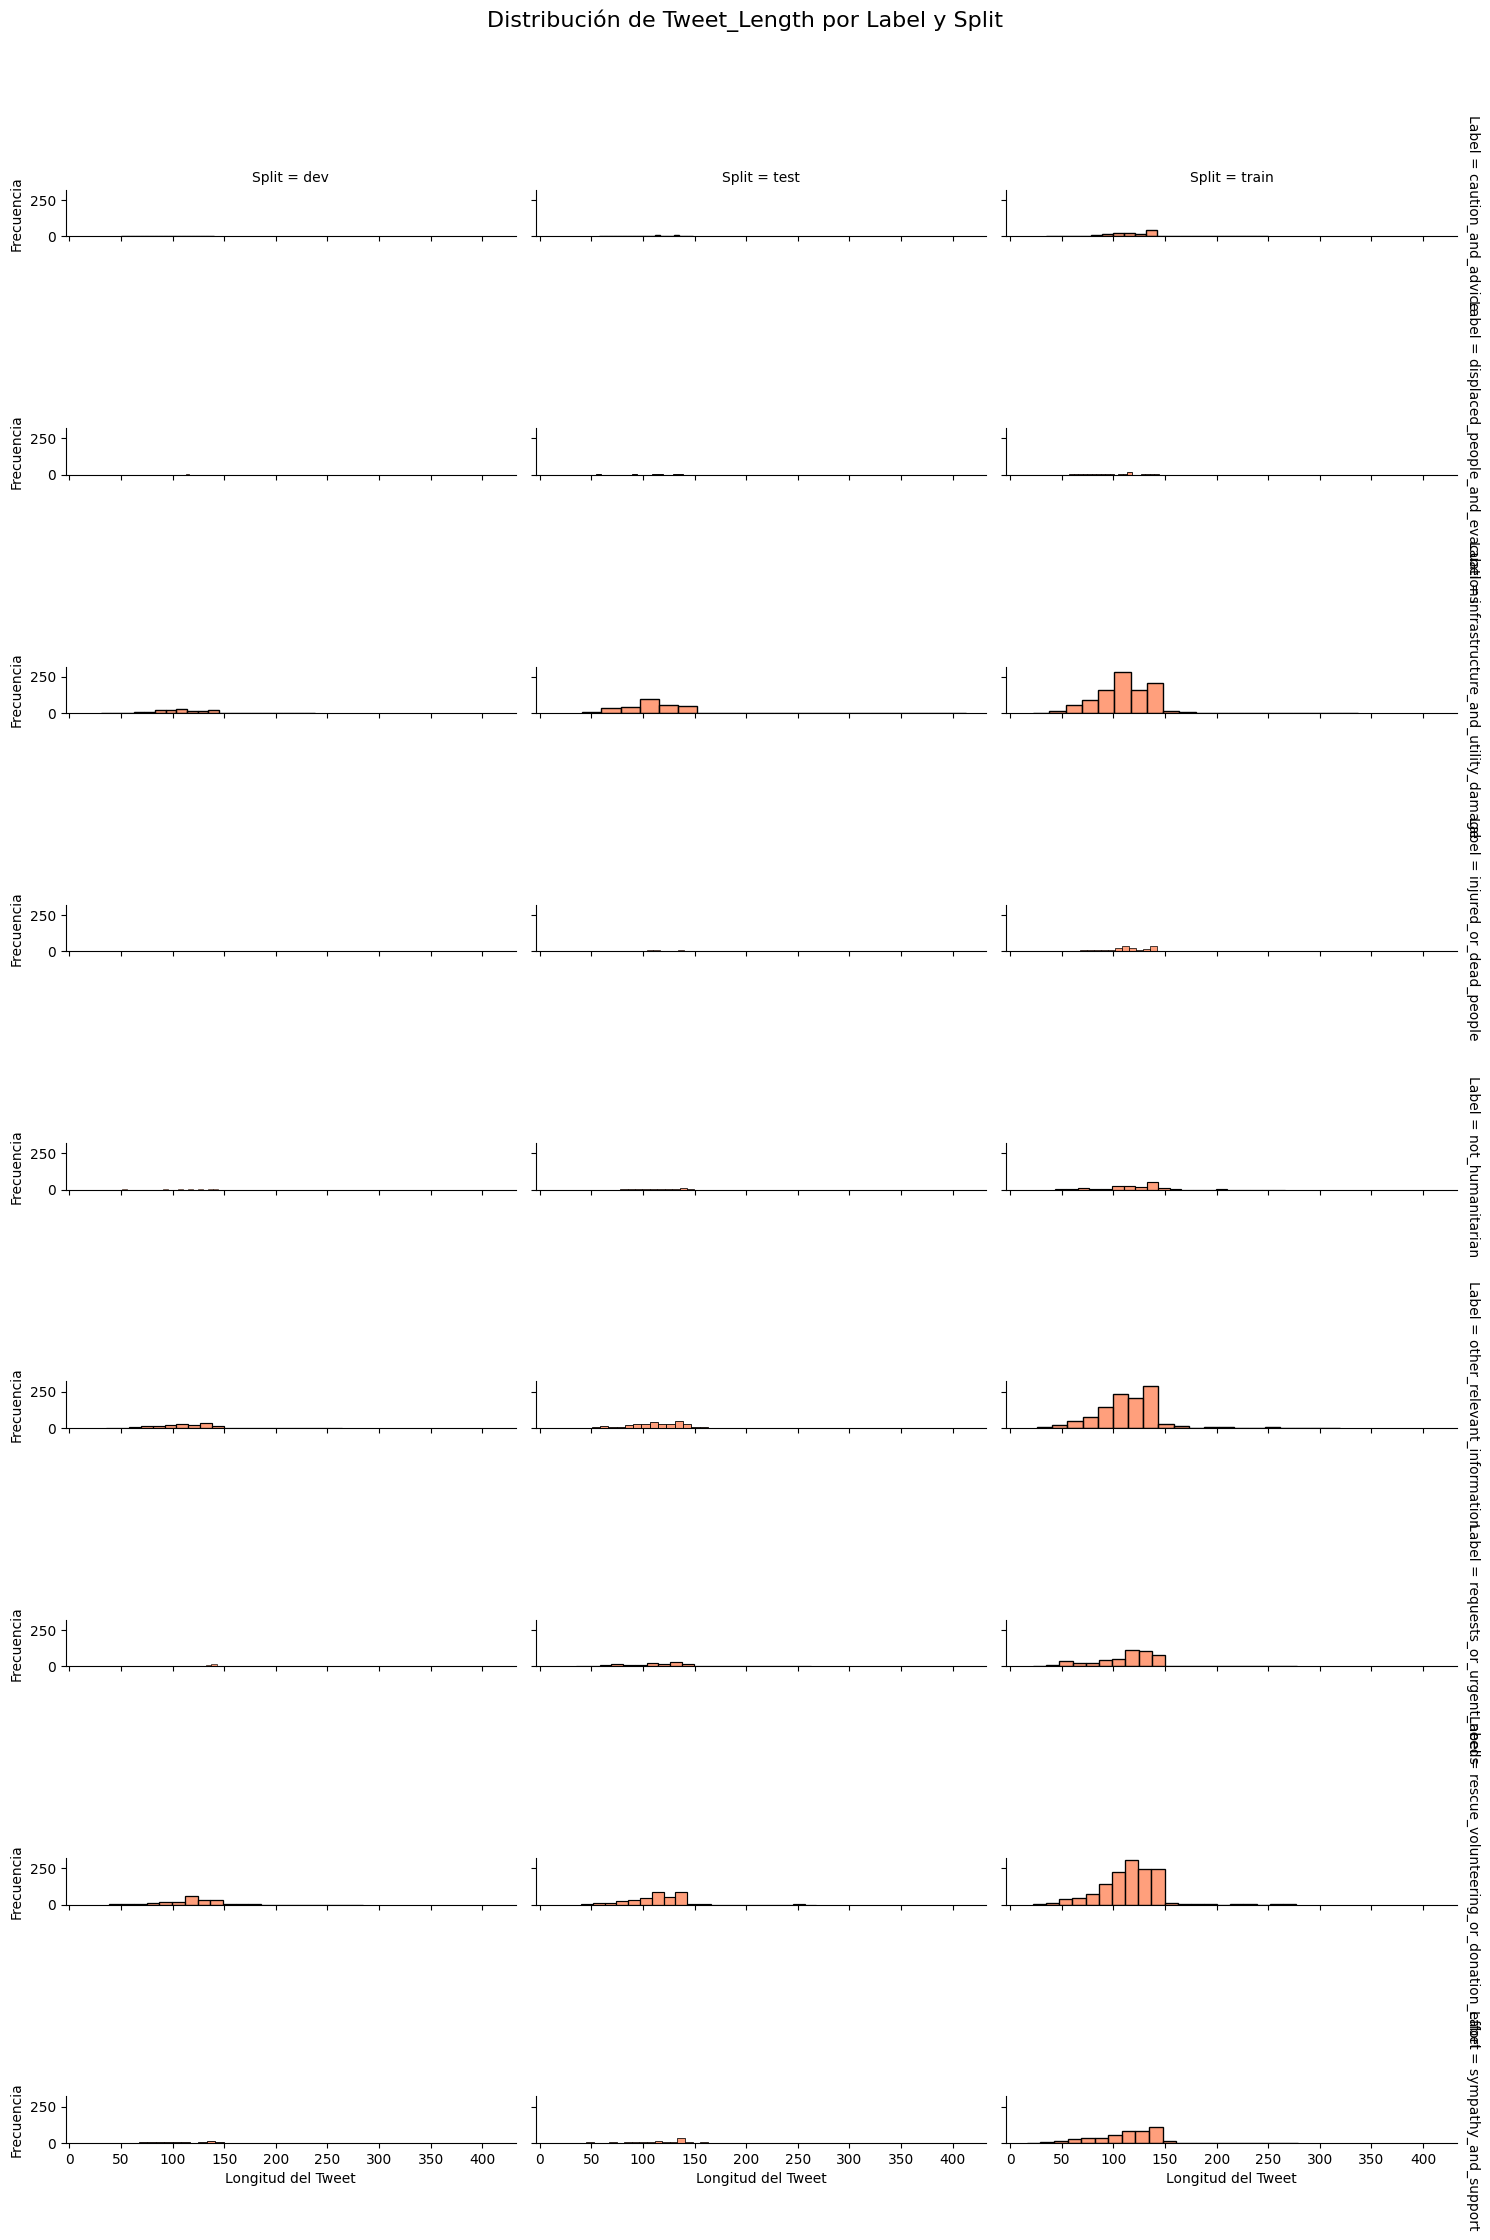

In [15]:
# ======================================================
# SECCIÓN K: Exploración Multivariable
# ======================================================
# Utilizando FacetGrid para explorar Tweet_Length por Label y Split
g = sns.FacetGrid(df_selected, col="Split", row="Label", margin_titles=True, height=2.5, aspect=2)
g.map(sns.histplot, "Tweet_Length", bins=20, color="coral")
g.set_axis_labels("Longitud del Tweet", "Frecuencia")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribución de Tweet_Length por Label y Split", fontsize=16)
plt.show()

### ✅ Análisis

- El gráfico muestra la **distribución de la longitud de los tweets (`Tweet_Length`)** separada por cada clase (`Label`) y por conjunto (`Split`: dev, test, train).
- Cada fila corresponde a una clase específica, y cada columna representa una partición del dataset.

#### 📌 Observaciones generales:

- Para todas las clases, la distribución de `Tweet_Length` se mantiene **consistente entre splits**, sin cambios abruptos en forma o rango.  
  Esto refuerza lo visto en la Sección I: **no hay evidencia de sesgo o data leakage** entre los subconjuntos.

- Las clases más frecuentes, como:
  - **`rescue_volunteering_or_donation_effort`**
  - **`other_relevant_information`**
  - **`infrastructure_and_utility_damage`**

  muestran una forma de campana bien definida en cada split, con la mayoría de los tweets entre **100 y 140 caracteres**.

- Clases con menos datos, como:
  - **`displaced_people_and_evacuations`**
  - **`not_humanitarian`**
  - **`injured_or_dead_people`**

  presentan una menor densidad y mayor variabilidad en las curvas, lo que es esperable por su menor cantidad de ejemplos.

📌 Conclusión:
Este análisis multivariable confirma que las **distribuciones por longitud se mantienen estables entre splits y dentro de cada clase**, lo cual es deseable para el entrenamiento y evaluación de modelos. También permite validar visualmente que no hay clases artificialmente sesgadas hacia cierto conjunto.

---

### Análisis Básico de Frecuencia de Palabras y Representación del Vocabulario

Este bloque de código realiza un análisis textual inicial sobre el dataset. Incluye:

- **Frecuencia de Palabras por Clase:**  
  Se utiliza `CountVectorizer` para extraer las palabras más frecuentes de cada categoría (`Label`) y se generan gráficos de barras horizontales para visualizar las 10 palabras más comunes.

- **N-gramas (Bigramas y Trigramas) por Clase:**  
  Se extraen y grafican los n-gramas (2 y 3 palabras consecutivas) para cada `Label`, lo que permite identificar frases clave y patrones contextuales.

- **Presencia de Palabras Clave por Clase:**  
  Se definen palabras de interés (por ejemplo, "agua", "alimentos", "medicina", "help", "donate") y se cuenta su frecuencia en cada etiqueta. Se visualizan estos datos en forma de gráfico de barras para facilitar la comparación.

- **Preanálisis del Vocabulario:**  
  Se calcula el tamaño total del vocabulario, la cantidad de palabras que aparecen solo una vez (hapax legomena) y la relación hapax/vocabulario, lo que ayuda a evaluar la diversidad léxica del conjunto de datos.

Este análisis básico permite comprender la representación léxica en los tweets y sirve como punto de partida para la ingeniería de características en modelos de NLP.


### Mejoras Avanzadas en el Análisis de Texto y N-gramas

Este bloque implementa mejoras para profundizar en la semántica del contenido, incluyendo:

1. **TF-IDF para n-gramas Distintivos:**  
   Se aplica `TfidfVectorizer` (configurado para unigramas, bigramas y trigramas) para identificar no solo los términos más frecuentes, sino los que son más distintivos en función de su ponderación TF-IDF.

2. **Visualización de Grupos Semánticos (UMAP y t-SNE):**  
   Se reducen las dimensiones de la matriz TF-IDF usando UMAP y t-SNE, lo que permite visualizar en 2D posibles clusters o agrupaciones semánticas de los tweets, coloreados según `Label`.

3. **Agrupación de Términos con Word2Vec:**  
   Se entrena un modelo Word2Vec con Gensim para obtener embeddings de palabras y agrupar términos equivalentes o semánticamente similares. Además, se visualizan los embeddings de las primeras 100 palabras con UMAP.

4. **Detección de Palabras Clave en Español:**  
   Utilizando `googletrans`, se traducen palabras clave definidas en español para facilitar la integración de textos bilingües y construir diccionarios semánticos.

5. **Reglas Heurísticas Basadas en N-gramas y Retweets:**  
   Se definen reglas simples (por ejemplo, si un tweet es retweet o contiene ciertas combinaciones de palabras) para asignar etiquetas de forma rápida, lo que puede servir como baseline o pre-filtro para modelos de clasificación.

Estas mejoras avanzadas permiten extraer features más sofisticadas, identificar agrupaciones semánticas y establecer reglas heurísticas que complementen los modelos de machine learning en tareas de clasificación de tweets.


In [30]:
import warnings
import re
import os  # For directory handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# ------------------------------
# Filtrar warnings innecesarios
# ------------------------------
warnings.filterwarnings("ignore", category=FutureWarning, 
                        message="'force_all_finite' was renamed to 'ensure_all_finite'")
warnings.filterwarnings("ignore", category=UserWarning, 
                        message="n_jobs value 1 overridden to 1 by setting random_state")

# Ensure "Tweet_Text" column is of string type
df_selected["Tweet_Text"] = df_selected["Tweet_Text"].astype(str)

# Change path to a relative or user-specific location
output_dir = './temp'  # Relative path; creates 'temp' in current working directory

# Ensure the directory exists
try:
    os.makedirs(output_dir, exist_ok=True)
    print(f"Directory '{output_dir}' created successfully.")
except Exception as e:
    print(f"Error creating directory '{output_dir}': {e}")

# ============================
# 1. Limpieza y Preprocesamiento Unificado
# ============================
def preprocess_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)    # Remove mentions (@user)
    text = re.sub(r"#", "", text)       # Remove hashtag symbol but keep content
    text = text.lower()                 # Convert to lowercase
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df_selected["Clean_Text"] = df_selected["Tweet_Text"].apply(preprocess_text)

# ============================
# 2. Frecuencia de Palabras y N-gramas (Optimizado)
# ============================
def plot_top_features_by_label(df, label, n_top=10, ngram_range=(1,1)):
    texts = df[df["Label"] == label]["Clean_Text"]
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    freqs = np.array(X.sum(axis=0)).flatten()
    vocab = np.array(vectorizer.get_feature_names_out())
    
    indices = freqs.argsort()[::-1][:n_top]
    top_items = vocab[indices]
    top_counts = freqs[indices]
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_items[::-1], top_counts[::-1], color="teal")
    title_ng = "words" if ngram_range == (1,1) else f"{ngram_range[0]}-{ngram_range[1]}-gramas"
    plt.title(f"Top {n_top} {title_ng} en '{label}'")
    plt.xlabel("Frecuencia")
    plt.tight_layout()
    
    # Save figure to /temp directory
    filename = f"{output_dir}/top_{n_top}_{title_ng}_{label}.png"
    plt.savefig(filename)
    print(f"Figure saved: {filename}")
    plt.close()

for lbl in df_selected["Label"].unique():
    plot_top_features_by_label(df_selected, lbl, n_top=10, ngram_range=(1,1))
    plot_top_features_by_label(df_selected, lbl, n_top=10, ngram_range=(2,2))
    plot_top_features_by_label(df_selected, lbl, n_top=10, ngram_range=(3,3))

# ============================
# 3. Presencia de Palabras Clave por Clase
# ============================
keywords = ["water", "food", "medicine", "help", "donate"]

def count_keywords(text, keywords):
    words = text.split()
    return {kw: words.count(kw) for kw in keywords}

keyword_data = []
for lbl in df_selected["Label"].unique():
    subset = df_selected[df_selected["Label"] == lbl]
    total = {kw: 0 for kw in keywords}
    for text in subset["Clean_Text"]:
        counts = count_keywords(text, keywords)
        for kw in keywords:
            total[kw] += counts[kw]
    keyword_data.append(total)

keyword_df = pd.DataFrame(keyword_data, index=df_selected["Label"].unique())
print("Frecuencia de palabras clave por Label:")
print(keyword_df)

keyword_df.plot(kind="bar", figsize=(10, 6))
plt.title("Frecuencia de palabras clave por Label")
plt.xlabel("Label")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()

# Save bar chart to /temp directory
filename_keywords = f"{output_dir}/keyword_frequencies.png"
plt.savefig(filename_keywords)
print(f"Figure saved: {filename_keywords}")
plt.close()

# ============================
# 5. TF-IDF Visualizations (UMAP and t-SNE)
# ============================
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_selected["Clean_Text"])

# UMAP Visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(10,8))
labels_numeric = pd.factorize(df_selected['Label'])[0]
scatter_umap = plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=labels_numeric, cmap='Spectral', s=5)
plt.colorbar(scatter_umap).set_ticks(np.arange(len(np.unique(labels_numeric))))
plt.title('UMAP de TF-IDF de Clean_Text')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()

filename_umap = f"{output_dir}/umap_visualization.png"
plt.savefig(filename_umap)
print(f"Figure saved: {filename_umap}")
plt.close()

# t-SNE Visualization
tsne_embedding = TSNE(n_components=2, random_state=42).fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(10,8))
scatter_tsne = plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=labels_numeric, cmap='Spectral', s=5)
plt.colorbar(scatter_tsne).set_ticks(np.arange(len(np.unique(labels_numeric))))
plt.title('t-SNE de TF-IDF de Clean_Text')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()

filename_tsne = f"{output_dir}/tsne_visualization.png"
plt.savefig(filename_tsne)
print(f"Figure saved: {filename_tsne}")
plt.close()


Directory './temp' created successfully.
Figure saved: ./temp/top_10_words_other_relevant_information.png
Figure saved: ./temp/top_10_2-2-gramas_other_relevant_information.png
Figure saved: ./temp/top_10_3-3-gramas_other_relevant_information.png
Figure saved: ./temp/top_10_words_caution_and_advice.png
Figure saved: ./temp/top_10_2-2-gramas_caution_and_advice.png
Figure saved: ./temp/top_10_3-3-gramas_caution_and_advice.png
Figure saved: ./temp/top_10_words_rescue_volunteering_or_donation_effort.png
Figure saved: ./temp/top_10_2-2-gramas_rescue_volunteering_or_donation_effort.png
Figure saved: ./temp/top_10_3-3-gramas_rescue_volunteering_or_donation_effort.png
Figure saved: ./temp/top_10_words_sympathy_and_support.png
Figure saved: ./temp/top_10_2-2-gramas_sympathy_and_support.png
Figure saved: ./temp/top_10_3-3-gramas_sympathy_and_support.png
Figure saved: ./temp/top_10_words_infrastructure_and_utility_damage.png
Figure saved: ./temp/top_10_2-2-gramas_infrastructure_and_utility_damage.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Ejemplos de análisis de sentimiento:
                                          Clean_Text  compound Sentiment_Label
0  san juan: trump lashes out with good reason. p...    0.4404        positive
1  hurricane maria live updates: catastrophic flo...   -0.4939        negative
2  getting food to the island is, obviously, crit...   -0.3182        negative
3  my heart breaks for the families in puerto ric...   -0.4738        negative
4  b-fast sending medical, reconstruction & water...    0.1027        positive
                                             Clean_Text  compound  \
7273  good lord, its true. puerto rico: teamsters un...    0.6908   
7274  litechnews: new yorkers pitch in to help with ...    0.7003   
7275  friendly reminder that this affects 3.5 millio...    0.7096   
7276  rt : 70,000 people need the worlds attention a...    0.4019   
7277  rt : across puerto rico, americans are still w...    0.5664   

     Sentiment_Label  
7273        positive  
7274        positive  
7275 

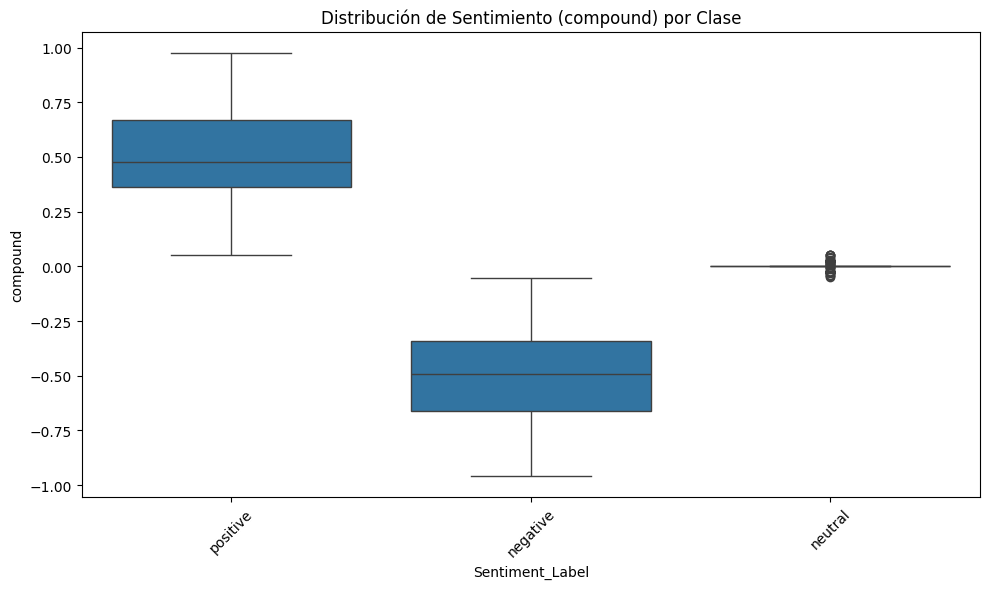

In [52]:
import os
import warnings
import re
import html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns

# ------------------------------
# Crear carpeta para guardar figuras (si no existe)
# ------------------------------
output_folder = "figures"
os.makedirs(output_folder, exist_ok=True)

# ------------------------------
# Filtrar warnings innecesarios
# ------------------------------
warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")
warnings.filterwarnings("ignore", category=UserWarning, message="n_jobs value 1 overridden to 1 by setting random_state")

# Asegura índice único y que "Tweet_Text" es string
df_selected = df_selected.copy()
df_selected.reset_index(drop=True, inplace=True)
df_selected["Tweet_Text"] = df_selected["Tweet_Text"].astype(str)

# ============================
# 1. Limpieza y Preprocesamiento Unificado
# ============================
def preprocess_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)     # Elimina URLs
    text = re.sub(r"@\w+", "", text)         # Elimina menciones
    text = re.sub(r"#", "", text)            # Elimina símbolo '#'
    text = html.unescape(text)               # Decodifica entidades HTML
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    return text

df_selected["Clean_Text"] = df_selected["Tweet_Text"].apply(preprocess_text)

# ============================
# 2. Aplicar VADER sin `apply()`
# ============================
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

compound_scores = []
for text in df_selected["Clean_Text"]:
    c = sia.polarity_scores(text)["compound"]
    compound_scores.append(c)

# Asigna la columna "compound" y la convierte a float
df_selected["compound"] = pd.to_numeric(compound_scores, errors="coerce")
df_selected["compound"] = df_selected["compound"].fillna(0.0).astype(float)

# Elimina columnas duplicadas (por ejemplo, si "compound" ya existía)
df_selected = df_selected.loc[:, ~df_selected.columns.duplicated()]

# ============================
# 3. Etiquetado de Sentimiento
# ============================
# Se asignan etiquetas usando operaciones vectorizadas (más eficiente y seguro)
df_selected["Sentiment_Label"] = np.where(df_selected["compound"] >= 0.05, "positive",
                                          np.where(df_selected["compound"] <= -0.05, "negative", "neutral"))

# Vemos algunos ejemplos
print("Ejemplos de análisis de sentimiento:")
print(df_selected[["Clean_Text", "compound", "Sentiment_Label"]].head())
print(df_selected[["Clean_Text", "compound", "Sentiment_Label"]].tail())

# ============================
# 4. Visualización
# ============================
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_selected, x="Sentiment_Label", y="compound")
plt.title("Distribución de Sentimiento (compound) por Clase")
plt.xticks(rotation=45)
plt.tight_layout()
filename = os.path.join(output_folder, "sentiment_distribution_by_label.png")
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
